## Pull from AWS S3

In [4]:
import boto3
import polars as pl
from io import StringIO

BUCKET = "kaggle-gold-dataset"
KEY = "gold_data_2015_25.csv"
REGION = "us-east-2"

s3 = boto3.client("s3", region_name=REGION)
obj = s3.get_object(Bucket=BUCKET, Key=KEY)
data = obj["Body"].read().decode("utf-8")

# load into Polars DataFrame
df = pl.read_csv(StringIO(data))

## Inspect the Data

In [5]:
print(df.head())

shape: (5, 6)
┌────────────┬─────────────┬────────────┬────────────┬───────┬──────────┐
│ Date       ┆ SPX         ┆ GLD        ┆ USO        ┆ SLV   ┆ EUR/USD  │
│ ---        ┆ ---         ┆ ---        ┆ ---        ┆ ---   ┆ ---      │
│ str        ┆ f64         ┆ f64        ┆ f64        ┆ f64   ┆ f64      │
╞════════════╪═════════════╪════════════╪════════════╪═══════╪══════════╡
│ 2015-01-02 ┆ 2058.199951 ┆ 114.080002 ┆ 159.119995 ┆ 15.11 ┆ 1.208941 │
│ 2015-01-05 ┆ 2020.579956 ┆ 115.800003 ┆ 150.320007 ┆ 15.5  ┆ 1.194643 │
│ 2015-01-06 ┆ 2002.609985 ┆ 117.120003 ┆ 144.399994 ┆ 15.83 ┆ 1.193902 │
│ 2015-01-07 ┆ 2025.900024 ┆ 116.43     ┆ 146.960007 ┆ 15.85 ┆ 1.187536 │
│ 2015-01-08 ┆ 2062.139893 ┆ 115.940002 ┆ 148.399994 ┆ 15.64 ┆ 1.1836   │
└────────────┴─────────────┴────────────┴────────────┴───────┴──────────┘


In [6]:
print(df.schema)

Schema({'Date': String, 'SPX': Float64, 'GLD': Float64, 'USO': Float64, 'SLV': Float64, 'EUR/USD': Float64})


In [7]:
print(df.describe())

shape: (9, 7)
┌────────────┬────────────┬─────────────┬────────────┬────────────┬───────────┬──────────┐
│ statistic  ┆ Date       ┆ SPX         ┆ GLD        ┆ USO        ┆ SLV       ┆ EUR/USD  │
│ ---        ┆ ---        ┆ ---         ┆ ---        ┆ ---        ┆ ---       ┆ ---      │
│ str        ┆ str        ┆ f64         ┆ f64        ┆ f64        ┆ f64       ┆ f64      │
╞════════════╪════════════╪═════════════╪════════════╪════════════╪═══════════╪══════════╡
│ count      ┆ 2666       ┆ 2666.0      ┆ 2666.0     ┆ 2666.0     ┆ 2666.0    ┆ 2666.0   │
│ null_count ┆ 0          ┆ 0.0         ┆ 0.0        ┆ 0.0        ┆ 0.0       ┆ 0.0      │
│ mean       ┆ null       ┆ 3504.231271 ┆ 158.601665 ┆ 80.319745  ┆ 19.414055 ┆ 1.118508 │
│ std        ┆ null       ┆ 1212.32334  ┆ 47.245813  ┆ 27.665948  ┆ 4.972436  ┆ 0.052239 │
│ min        ┆ 2015-01-02 ┆ 1829.079956 ┆ 100.5      ┆ 17.040001  ┆ 11.21     ┆ 0.959619 │
│ 25%        ┆ null       ┆ 2467.419922 ┆ 120.650002 ┆ 67.839996  ┆ 15.53   

In [8]:
print(df.shape)

(2666, 6)


## Basic Filtering & Grouping

In [9]:
# filter: GLD > 180
high_gold = df.filter(pl.col("GLD") > 180)
print(high_gold.shape)

(614, 6)


In [10]:
# Normalize Date dtype (works whether it's already date or a string)
df = df.with_columns(pl.col("Date").cast(pl.Date))

# Add Year column
df = df.with_columns(pl.col("Date").dt.year().alias("Year"))

# Group by Year and compute average GLD
yearly_avg = df.group_by("Year").agg(pl.col("GLD").mean().alias("avg_GLD"))
print(yearly_avg)

shape: (11, 2)
┌──────┬────────────┐
│ Year ┆ avg_GLD    │
│ ---  ┆ ---        │
│ i32  ┆ f64        │
╞══════╪════════════╡
│ 2015 ┆ 111.146032 │
│ 2019 ┆ 131.561872 │
│ 2017 ┆ 119.71494  │
│ 2016 ┆ 119.362619 │
│ 2018 ┆ 120.177331 │
│ …    ┆ …          │
│ 2023 ┆ 180.44988  │
│ 2020 ┆ 166.653755 │
│ 2024 ┆ 221.099484 │
│ 2021 ┆ 168.31123  │
│ 2022 ┆ 167.905139 │
└──────┴────────────┘


## Visualization

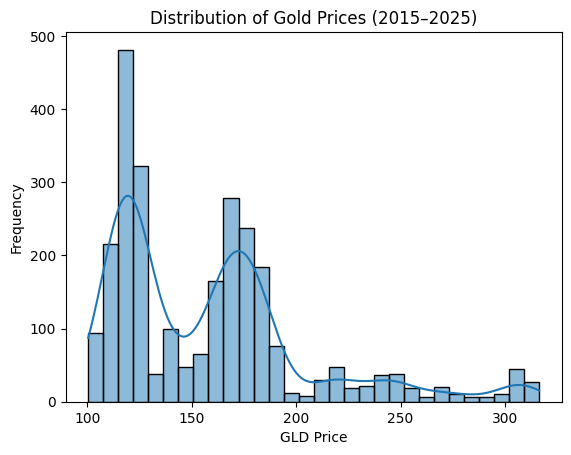

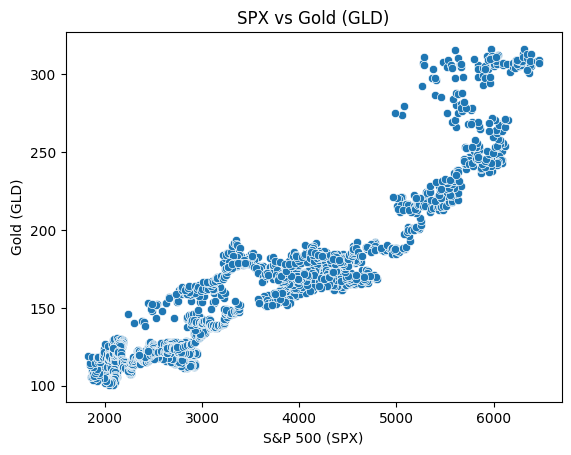

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
gld = df["GLD"].to_numpy()
sns.histplot(gld, bins=30, kde=True)
plt.title("Distribution of Gold Prices (2015–2025)")
plt.xlabel("GLD Price")
plt.ylabel("Frequency")
plt.show()

# Scatter: SPX vs GLD
spx = df["SPX"].to_numpy()
gld = df["GLD"].to_numpy()
sns.scatterplot(x=spx, y=gld)
plt.title("SPX vs Gold (GLD)")
plt.xlabel("S&P 500 (SPX)")
plt.ylabel("Gold (GLD)")
plt.show()

## ML Exploration

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Convert Polars → NumPy for sklearn
X = df.select(["SPX", "USO", "SLV", "EUR/USD"]).to_numpy()
y = df["GLD"].to_numpy()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R² score:", r2)
print("MSE:", mse)
print("RMSE:", rmse)

R² score: 0.9209794176809402
MSE: 164.3545661729492
RMSE: 12.82008448384601


In [13]:
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Features/target from Polars to NumPy
X = df.select(["SPX", "USO", "SLV", "EUR/USD"]).to_numpy()
y = df["GLD"].to_numpy()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit XGBoost Regressor
model = XGBRegressor(
    n_estimators=500,       # number of trees
    learning_rate=0.05,     # step size shrinkage
    max_depth=4,            # complexity of trees
    subsample=0.8,          # row sampling (regularization)
    colsample_bytree=0.8,   # feature sampling (regularization)
    random_state=42,
    reg_lambda=1,           # L2 regularization
    n_jobs=-1
)

model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
def eval_metrics(y_true, y_pred, label="Test"):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{label} R²: {r2:.4f}")
    print(f"{label} MSE: {mse:.4f}")
    print(f"{label} RMSE: {rmse:.4f}")
    print("-" * 30)

eval_metrics(y_train, y_train_pred, "Train")
eval_metrics(y_test, y_test_pred, "Test")

Train R²: 0.9989
Train MSE: 2.5984
Train RMSE: 1.6120
------------------------------
Test R²: 0.9932
Test MSE: 14.2006
Test RMSE: 3.7684
------------------------------
